# An Introduction to Autoencoders

*This is one writeup in what I'm hoping to make a series of posts on representation learning and unsupervised methods in general. I've noticed that there are far fewer resources out there detailing these topics than there are for common supervised learning topics, and next-to-none that show them off in practice (i.e. with code) along with the underlying math. I'd like these posts to be accessible to a wider audience while still providing mathematical intuition.*

## Part 1: Motivation and Introduction
*What is an autoencoder and why should I care?*

The core concept underlying all autoencoders is deceptively simple. Let's break it down from the name instead of memorizing it as just another term. The word 'autoencoder' is made up of 'auto,' meaning self, and 'encoder,' meaning something that transforms information in one form (or code) to another. An autoencoder is a neural network that takes in data, transforms it, and tries to output the same data that it was given. 

Cool. We now know what an autoencoder is. Article over, right? Well, not quite.

Our definition as it currently stands makes sense, but seems rather... useless. Why go through the trouble of training a neural network to get an imperfect approximation of the identity function when we could just return our input data? The answer is that we don't really care about the output of our network itself; in fact, when using autoencoders, we never even expect it to perfectly output the data we gave it as input. What's of importance to us is the _transformation_ step. All autoencoders 
possess some transformed intermediate state of the data between the input and output, called the **code**. The part of the autoencoder that outputs the code is unsurprisingly referred to as the **encoder**, while the remainder (which tries to reconstruct the input from the code) is perhaps even more unsurprisingly dubbed the **decoder**. 

![title](diagrams/undercomplete_ae.png)
**An illustration of an autoencoder.** Our input data $\boldsymbol x$ is fed into the encoder function $f$ to create the code; the code is in turn fed into the decoder $\boldsymbol g$ to obtain the output, which we will compare to our input. (In particular, this is visually closest to an _undercomplete_ autoencoder, described in the next section.

As things currently stand, however, this 'code' doesn't seem particularly useful either. One can easily imagine a neural network with enough capacity being perfectly happy to create some arbitrary approximately invertible function as the encoder and its inverse as the decoder, changing both in tandem to get the identity function as their composite. But the key to (useful) autoencoders is that we aren't going to let our network learn the identity function alone; we're instead going to bully it into learning a code with properties we'd like to have in a(n approximately invertible) transformation of our data at the expense of being able to perfectly reconstruct the input.

Thus, autoencoders are an extremely powerful framework for _representation learning_. Once we come up with properties we'd like to have in a representation of our data, we can try and constrain our network to learn a code with those properties. 

## Part 2:  Undercomplete Autoencoders

Now that we have this framework in mind, let's think of properties we might like a representation to have. Oftentimes, the data we are working with is high-dimensional in nature. In order to avoid the curse of dimensionality or to extract semantically meaningful features, we might want some low-dimensional representation of our high-dimensional data -- hence the existence of a whole host of dimensionality reduction techniques in the literature, most well-known being by way of principal components analysis (PCA). (This was actually the original motivation behind the autoencoder, and can be considered the most 'vanilla' flavor of them.) 

Thus, we bottleneck the number of dimensions in our network at the code to be lower than the number of dimensions in the input data. We then structure our decoder as a function from the lower number of dimensions to the original number to bring it back up.

Let's see what that looks like in code instead of words! For our first autoencoder, we'll use simple linear transformations for encoding and decoding so we can reason about what's going on intuitively, but keep in mind the main power behind autoencoders comes from their use of neural networks (i.e. incredibly versatile function approximators) for both steps.

In [1]:
# imports
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')

import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

torch.manual_seed(42); # set seed for consistent results

We first must define how many dimensions we want the code to be. This is highly dependent on the number of dimensions in the input -- there is no magic number you can always pick that will give you the results you want! (It also depends on what you plan on using the code for; but these are considerations for downstream tasks.) 

In [2]:
input_dimensions = 784
code_dimensions = 32

We're going to define classes for the encoder and decoder networks. This might seem redundant with our small network now, but is good practice for making encoders and decoders with more complicated architectures than a single linear layer.

In [3]:
class Encoder(nn.Module):
    """
    Encoder class for linear autoencoder. Takes in data of dimension `input_dimensions`, 
    conducts a linear transformation, and outputs the resulting code of dimension `code_dimensions`.
    """
    def __init__(self, input_dimensions: int, code_dimensions: int):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dimensions, code_dimensions, bias=False)
    def forward(self, x: torch.Tensor):
        return self.fc1(x)

In [4]:
class Decoder(nn.Module):
    """
    Decoder class for linear autoencoder. Takes in data of dimension `code_dimensions`, 
    conducts a linear transformation, and outputs the resulting output of dimension `input_dimensions`.
    """
    def __init__(self, code_dimensions: int, input_dimensions: int):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(code_dimensions, input_dimensions, bias=False)
    def forward(self, x: torch.Tensor):
        return self.fc1(x)

Our full autoencoder is then the encoder followed by the decoder.

In [5]:
class LinearAutoencoder(nn.Module):
    """
    Class for linear autoencoder. Composite of Encoder and Decoder classes above.
    """
    def __init__(self, input_dimensions: int, code_dimensions: int):
        super(LinearAutoencoder, self).__init__()
        self.encode = Encoder(input_dimensions, code_dimensions)
        self.decode = Decoder(code_dimensions, input_dimensions)
    def forward(self, x: torch.Tensor):
        x = self.encode(x) # from input_dimensions->code_dimensions...
        x = self.decode(x) # and back from code_dimensions->input_dimensions
        return x

Now we have some general setup to do before we can get training, but this is somewhat usecase-specific and not that important to understanding autoencoders conceptually.

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [7]:
# some hyperparameters
batch_sz = 32
test_batch_sz = 100

learning_rate = 10**(-1.5)
momentum = 0.5

n_epochs = 20

In [8]:
# set dataloader kwargs
kwargs = {'num_workers': 1, 'pin_memory':True} if torch.cuda.is_available() else {}

In [9]:
# preprocessing
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [10]:
# create dataloaders to serve up MNIST images as example data -- see MNIST example in the official documentation 
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform= img_transform),
    batch_size=batch_sz,
    shuffle=True,
    **kwargs
)

In [11]:
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=img_transform),
    batch_size=test_batch_sz,
    shuffle=True,
    **kwargs
)

We'll set up our model and use stochastic gradient descent with momentum as our optimizer (simplicity is always best when complexity isn't necessary!).

In [12]:
model = LinearAutoencoder(input_dimensions, code_dimensions).to(device)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

In [13]:
def train(model: nn.Module, optimizer: torch.optim.Optimizer, device: torch.device, 
          train_loader: torch.utils.data.dataloader.DataLoader, epoch: int):
    """
    Executes one epoch of training given a model, optimizer, device, dataloader, and epoch number.
    """
    model.train()
    for batch_idx, (inp, label) in enumerate(train_loader):
        inp = inp.view(-1, input_dimensions)
        inp = inp.to(device) 
        output = model(inp) # here we put the input image through the autoencoder
        loss = F.mse_loss(output, inp) # then compare output to input via mean-square-error
        
        # good to check that our values are still sane and nothing has gone horribly wrong
        if torch.isnan(loss).any() or loss.item() == np.inf or loss.item() == -np.inf:
            print('Gradient vanished/exploded')
            raise Exception('Died')
            break
        
        loss.backward() # compute gradients
        optimizer.step() # conduct step of gradient descent
        optimizer.zero_grad() # zero out gradients to avoid messing with future iterations
        
        if batch_idx % 1000 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inp), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [14]:
def test(model: nn.Module, device: torch.device, test_loader: torch.utils.data.dataloader.DataLoader, epoch: int):
    """
    Computes error on test set given a model, device, dataloader, and epoch number.
    """
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch_idx, (inp, label) in enumerate(test_loader):
            inp = inp.view(-1, input_dimensions)
            inp = inp.to(device)
            output = model(inp)
            test_loss += F.mse_loss(output, inp)
    
    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}\n'.format(test_loss))

All that's left is to train our model and see the results!

In [15]:
for epoch in range(1, n_epochs+1):
    train(model, optimizer, device, train_loader, epoch)
    test(model, device, test_loader, epoch)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.000938
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.257497

Test set: Average loss: 0.0025

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.244470
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.238129

Test set: Average loss: 0.0024

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.222586
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.237073

Test set: Average loss: 0.0021

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.208160
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.203348

Test set: Average loss: 0.0019

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.197845
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.175188

Test set: Average loss: 0.0017

Train Epoch: 6 [0/60000 (0%)]	Loss: 0.181806
Train Epoch: 6 [32000/60000 (53%)]	Loss: 0.155630

Test set: Average loss: 0.0016

Train Epoch: 7 [0/60000 (0%)]	Loss: 0.153001
Train Epoch: 7 [32000/60000 (53%)]	Loss: 0.155533

Test set: Average loss: 0.0015

Train Epoch: 8 [0/60000 (0%)]	Loss: 0.154720
Train Epoch: 8 [32000/60000 (53%)]	Loss: 0.156239

Test set

We ended up with a test MSE of 0.001. Is this good? Well, as far as the quality of the reconstruction goes, it seems pretty decent in some handwavey sense considering our values range from 0 to 1. But humans are visual creatures: best way to see how it's doing is to actually see it!

In [16]:
# function to un-normalize the output of the network to make it look like the original images
def to_img(x: torch.Tensor):
    x = 0.5 * (x + 1)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [17]:
# get an example batch and push it through the network
with torch.no_grad():
    x = next(iter(test_loader))[0].to(device)
    x = x.view(-1,input_dimensions)
    y = model(x)
    y = to_img(y)

Displaying our example and its corresponding output,

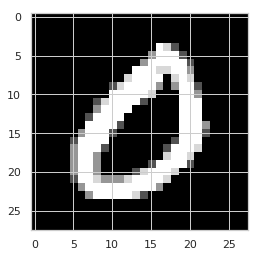

In [18]:
plt.imshow(x[0].view(28,28).cpu().numpy(), cmap='Greys_r')

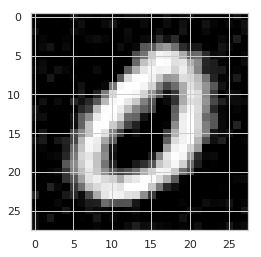

In [19]:
plt.imshow(y[0].view(28,28).cpu().numpy(), cmap='Greys_r')

with the (uninterpretable) 32-dimensional code as

In [20]:
model.encode(x)[0].detach().cpu().numpy()

array([ 1.2461367 ,  0.7578721 , -0.80333775,  0.17708406,  2.0784078 ,
       -1.2867155 ,  0.459029  , -2.3941464 ,  0.10984115,  0.59566885,
       -1.8090788 , -2.0377617 , -2.190893  ,  0.2924345 , -0.20564324,
        0.10396053, -3.552227  , -1.2485214 , -0.8760196 , -1.0671576 ,
       -3.8653336 , -0.44916114,  1.0365984 ,  1.1902565 , -0.1348641 ,
        0.2300794 ,  0.6650476 , -1.5262647 ,  3.0209737 ,  0.59753466,
        0.12191479, -3.11799   ], dtype=float32)

We can see that the output still is very clearly a 1, but is not quite the same as what we put in. This should make sense to us as we did essentially did some lossy compression by a factor of 24.5x -- definitely non-negligible! The autoencoder learned what combinations of the input dimensions it could make in 32 dimensions to best squeeze as much information in as possible to be able to reconstruct the input. 

## Part 3: Conclusion

In this post, we took a look at the inner workings of the simplest variety of autoencoder, the undercomplete autoencoder; that is, a neural network that maps its input to itself with an intermediate layer of fewer dimensions. But this is just the beginning! More importantly, we introduced the autoencoder as a framework for representation learning given how we apply constraints. In the future, we'll see how this can be used for things other than dimension reduction.

### Postscript

P.S. In this case, we only allowed its combinations to be linear by construction of our encoder and decoder. As a fun note, this should feel very familiar to the linear algebra types out there: what we have is a special case of autoencoder construction that's equivalent to principal components analysis (PCA). Given our data is mean-centered here, this just means our network is learning to project into the subspace of the eigenspace spanned by the first $32$ eigenvectors (ordered by 'importance'/magnitude of eigenvalue). An brief, handwavey outline of why this is the case: PCA can be thought of as trying finding the subspace we can project into that minimizes reconstruction error of how far our projections are from the original points; this is what a linear autoencoder is also doing.